In [69]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from skimage import io
from tensorflow import keras
from tensorflow.keras import preprocessing, models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization
import matplotlib.pyplot as plt
from glob import glob

# 1. Data Reading/Data Understanding

In [70]:
train_dir = pathlib.Path("../../datasets/images/melanoma/train")
test_dir = pathlib.Path('../../datasets/images/melanoma/test')

In [71]:
train_images_count = len(list(train_dir.glob('*/*.jpg')))
print(train_images_count)
test_images_count = len(list(test_dir.glob('*/*.jpg')))
print(test_images_count)

2239
118


In [72]:
batch_size = 32
image_height = 180
image_width = 180
validate_split = 0.2
seed = 123
epochs = 20

train_images_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    validation_split=validate_split,
    subset='training',
    seed=seed
    )

validation_images_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width),    
    validation_split=validate_split,
    subset='validation',
    seed=seed)

test_images_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


# 2. Visualize the data

In [73]:
def plot_images(image_ds, image_dir):
    class_names = image_ds.class_names
    images_path = []
    for i in range(len(class_names)):
        image_class_path = os.path.join(image_dir, class_names[i])
        image_path = list(pathlib.Path(image_class_path).glob('*.jpg'))[0]
        images_path.append(image_path)

    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        image = io.imread(images_path[i])
        ax.set_title(images_path[i], fontsize=8)
        ax.imshow(image)
    plt.tight_layout()
    plt.show()

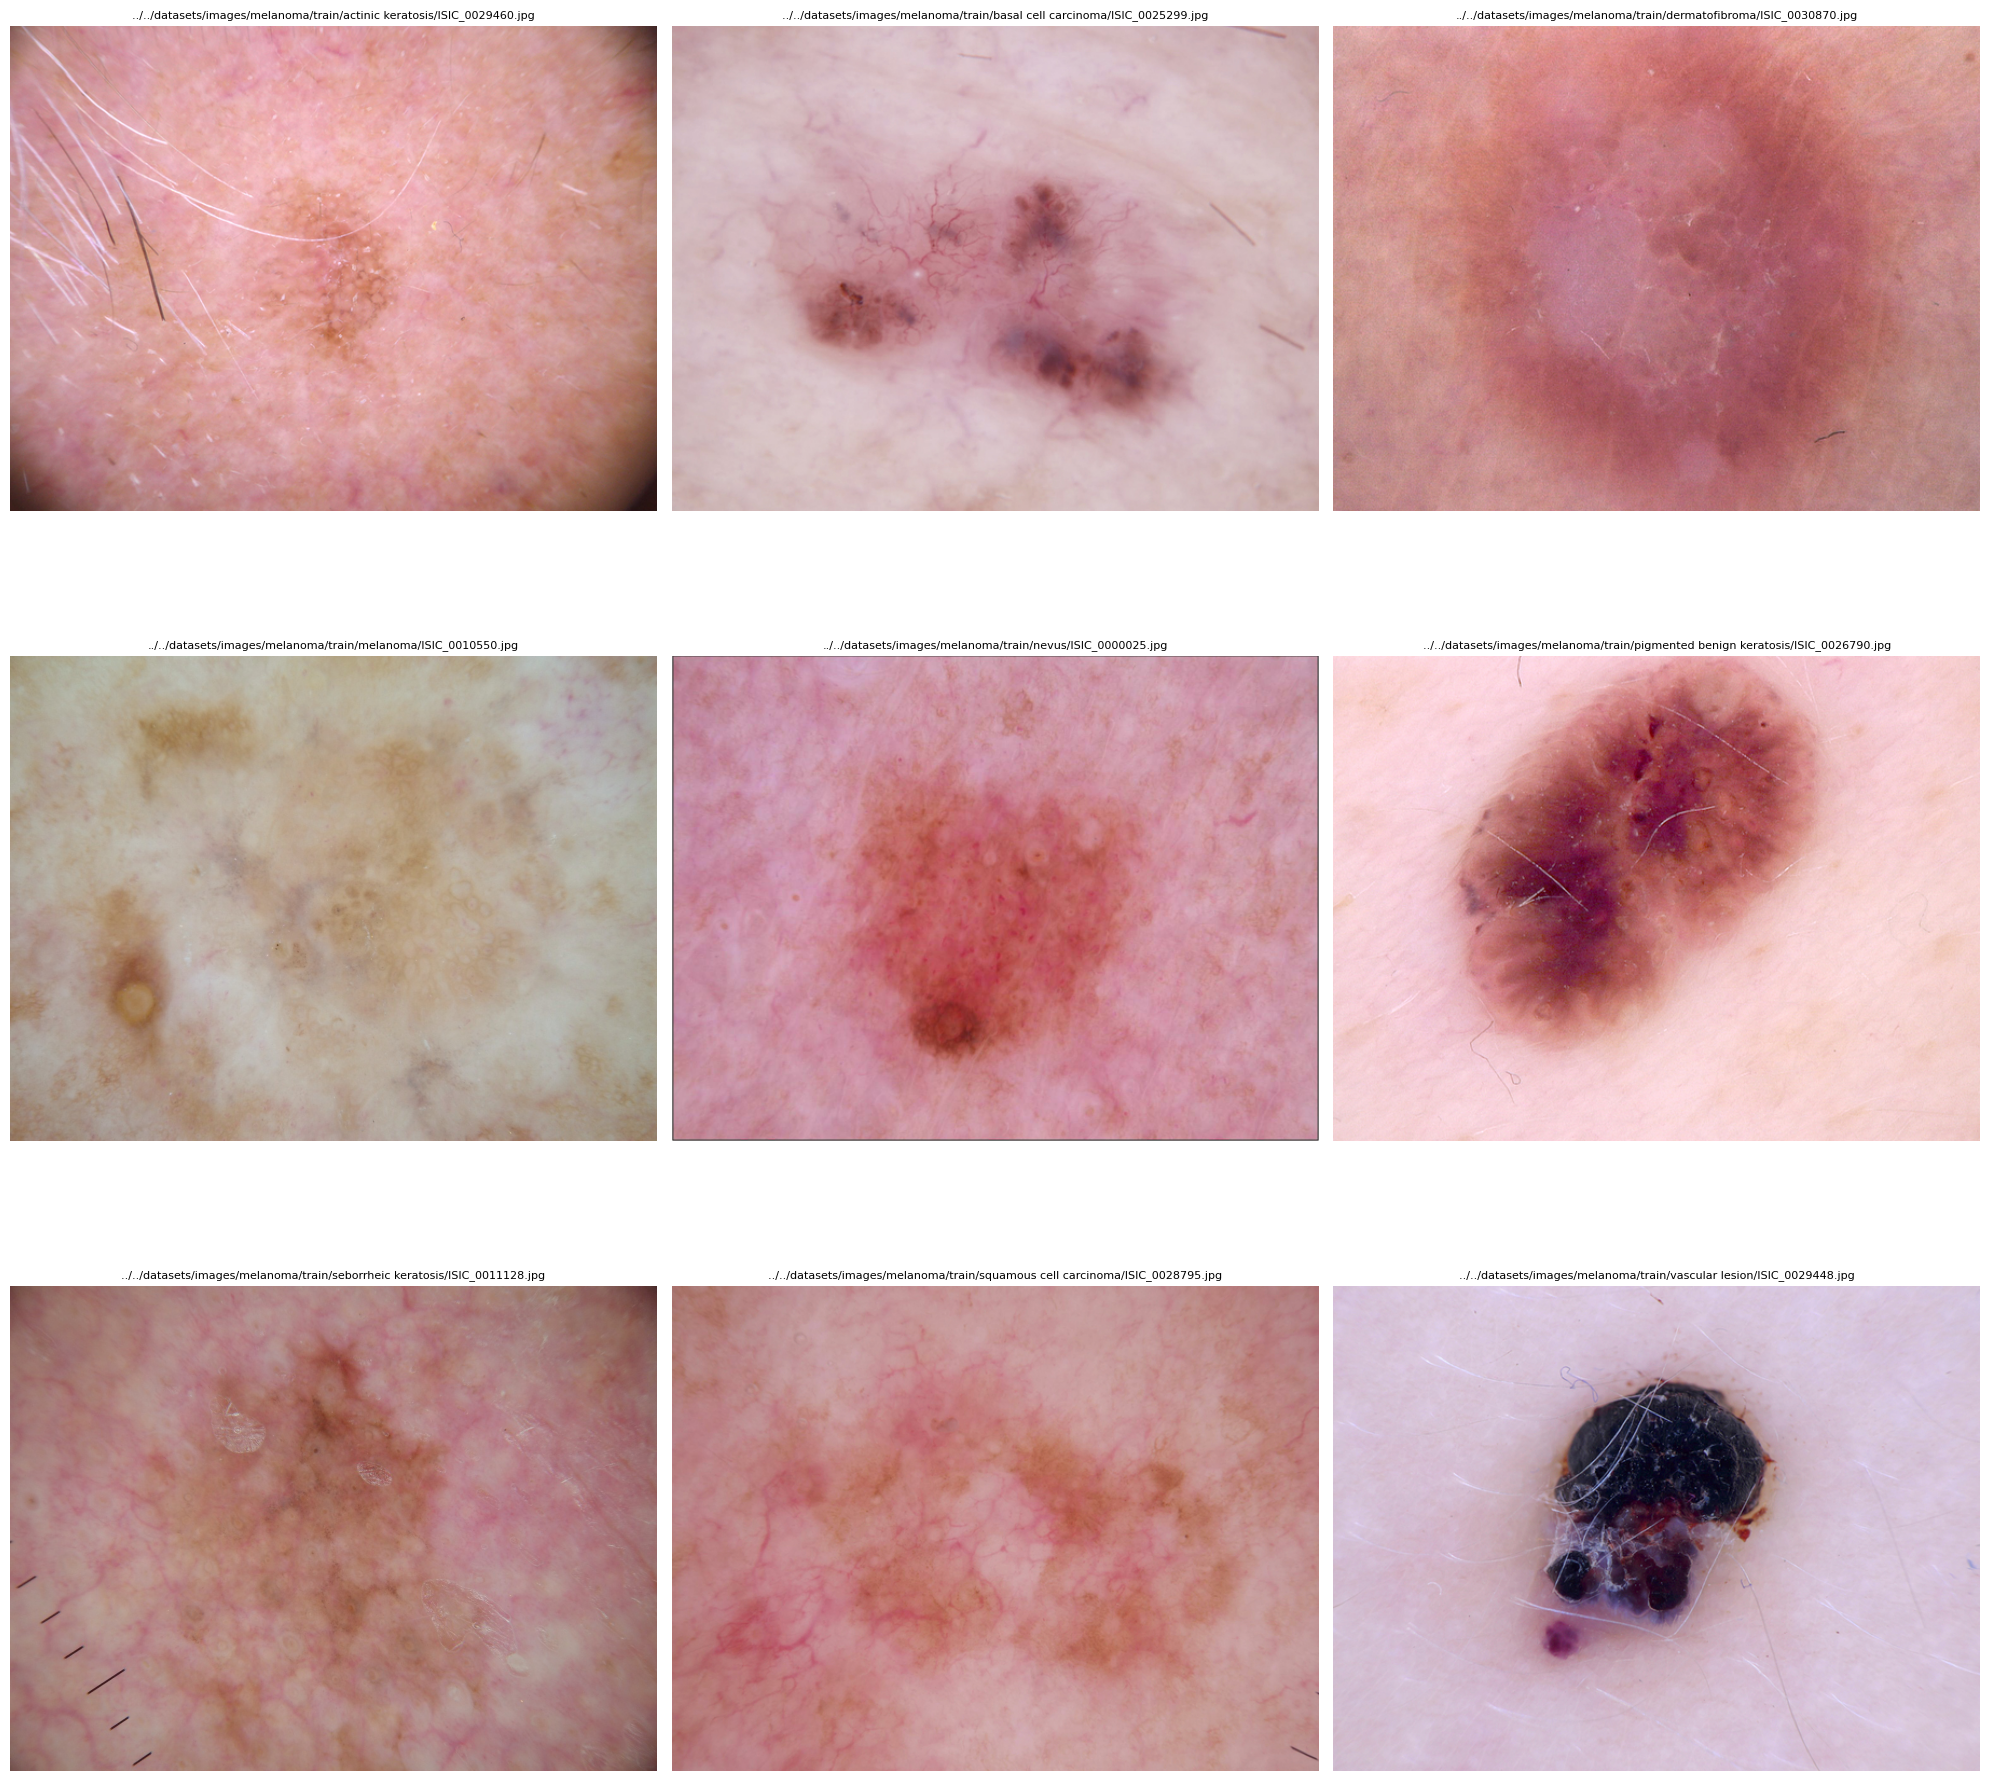

In [74]:
plot_images(train_images_ds, train_dir)

# 3. Create the model

In [75]:
def plot_model_accuracy(model, epochs):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## 3.1 Simple Model with 2 Convolution and 1 Dense Layers

In [76]:
input_shape = (image_height, image_width, 3)
num_classes = len(train_images_ds.class_names)
model = models.Sequential()

# 0th Input Layer
model.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer
model.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2,2))

# 2nd Convolution Layer
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2,2))

# 3rd Dense Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# 4th Output Layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
final_model = model.fit(train_images_ds, validation_data=validation_images_ds, epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.2377 - loss: 3.1629 - val_accuracy: 0.4743 - val_loss: 1.5739
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - accuracy: 0.4185 - loss: 1.6409 - val_accuracy: 0.4519 - val_loss: 1.6933
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - accuracy: 0.4914 - loss: 1.4521 - val_accuracy: 0.4922 - val_loss: 1.5386
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.5331 - loss: 1.2894 - val_accuracy: 0.5123 - val_loss: 1.5447
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.5779 - loss: 1.1810 - val_accuracy: 0.5280 - val_loss: 1.5861
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.6528 - loss: 1.0042 - val_accuracy: 0.5369 - val_loss: 1.5594
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.6678 - loss: 0.9387 - val_accuracy: 0.5235 - val_loss: 1.5287
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.6944 - loss: 0.8946 - val_accu

#### Observations:
- Training Accuracy = 91.03%
- Validation Accuracy = 51.9%
- As the training progressed, the training accuracy kept increasing while the validation accuracy kept decreasing.
- Model is **overfitting**.

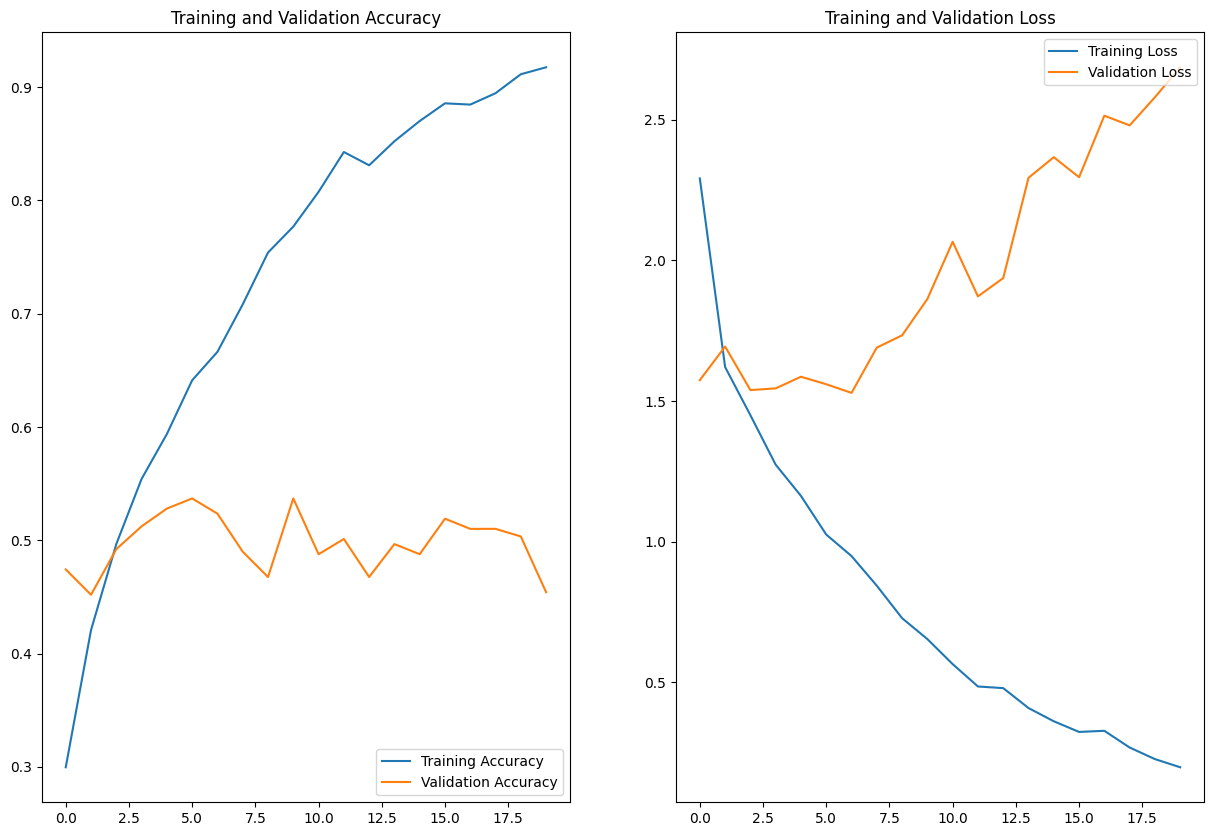

In [78]:
plot_model_accuracy(final_model, epochs)

## 3.2 Simple Model with 2 Convolution, 1 Dense Layer and Dropout Layers

In [79]:
input_shape = (image_height, image_width, 3)
num_classes = len(train_images_ds.class_names)
model_with_dropout = models.Sequential()

# 0th Input Layer
model_with_dropout.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer 
model_with_dropout.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_with_dropout.add(MaxPooling2D(2,2))
model_with_dropout.add(Dropout(0.25))

# 2nd Convolution Layer
model_with_dropout.add(Conv2D(64, 3, activation='relu'))
model_with_dropout.add(MaxPooling2D(2,2))
model_with_dropout.add(Dropout(0.25))

# 3rd Dense Layer
model_with_dropout.add(Flatten())
model_with_dropout.add(Dense(128, activation='relu'))
model_with_dropout.add(Dropout(0.25))

# 4th Output Layer
model_with_dropout.add(Dense(num_classes, activation='softmax'))

model_with_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_dropout.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
final_model_with_dropout = model_with_dropout.fit(train_images_ds, validation_data=validation_images_ds, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.1753 - loss: 5.1391 - val_accuracy: 0.2729 - val_loss: 2.1565
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.2721 - loss: 1.9610 - val_accuracy: 0.3378 - val_loss: 2.0123
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.3780 - loss: 1.7646 - val_accuracy: 0.4519 - val_loss: 1.7269
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.4361 - loss: 1.6209 - val_accuracy: 0.4765 - val_loss: 1.6044
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.4906 - loss: 1.5013 - val_accuracy: 0.5101 - val_loss: 1.5387
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.4787 - loss: 1.4737 - val_accuracy: 0.4832 - val_loss: 1.5036
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.4951 - loss: 1.3931 - val_accuracy: 0.5235 - val_loss: 1.4612
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.5481 - loss: 1.3149 - val_accu

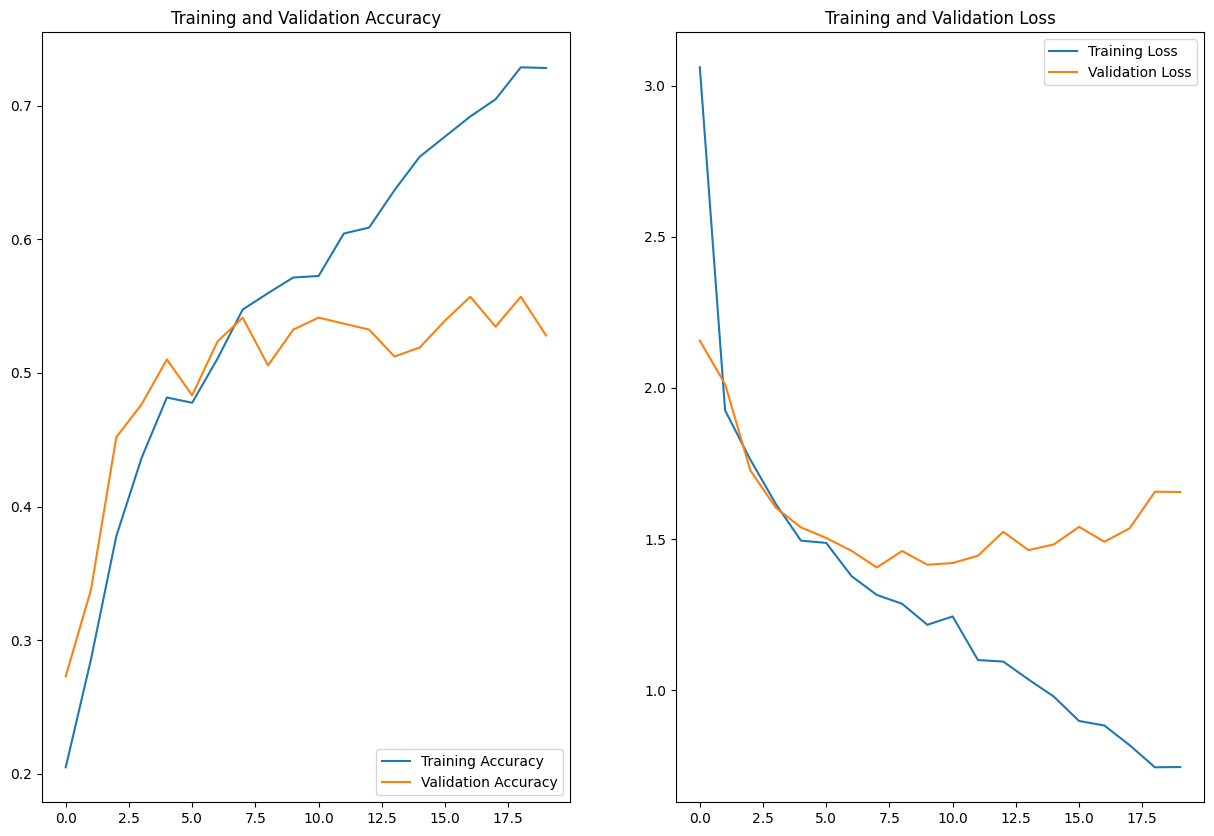

In [81]:
plot_model_accuracy(final_model_with_dropout, epochs)

#### Observations:
- Training Accuracy = 70.09 %
- Validation Accuracy = 50.34 %
- As the training progressed, both the training accuracy and the validation accuracy kept increasing.
- Difference between the training and validation accuracies narrowed as compared to without dropouts.
- The training accuracy is less as compared to model without dropout.
- Model is **overfitting**.

## 3.3 Model with 2 Convolution, 1 Dense Layer and Batch Normalisation

In [82]:
input_shape = (image_height, image_width, 3)
num_classes = len(train_images_ds.class_names)
model_with_batch_normalisation = models.Sequential()

# 0th Input Layer
model_with_batch_normalisation.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer 
model_with_batch_normalisation.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_with_batch_normalisation.add(BatchNormalization())
model_with_batch_normalisation.add(MaxPooling2D(2,2))

# 2nd Convolution Layer
model_with_batch_normalisation.add(Conv2D(64, 3, activation='relu'))
model_with_batch_normalisation.add(BatchNormalization())
model_with_batch_normalisation.add(MaxPooling2D(2,2))

# 3rd Dense Layer
model_with_batch_normalisation.add(Flatten())
model_with_batch_normalisation.add(Dense(128, activation='relu'))
model_with_batch_normalisation.add(BatchNormalization()),

# 4th Output Layer
model_with_batch_normalisation.add(Dense(num_classes, activation='softmax'))

model_with_batch_normalisation.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_batch_normalisation.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [83]:
final_model_with_batch_normalisation = model_with_batch_normalisation.fit(train_images_ds, validation_data=validation_images_ds, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3428 - loss: 2.3856 - val_accuracy: 0.1499 - val_loss: 2.2309
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.5273 - loss: 1.3732 - val_accuracy: 0.1499 - val_loss: 2.8378
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6084 - loss: 1.1438 - val_accuracy: 0.1499 - val_loss: 3.2249
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - accuracy: 0.6506 - loss: 1.0149 - val_accuracy: 0.1544 - val_loss: 3.1353
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.7121 - loss: 0.8477 - val_accuracy: 0.2237 - val_loss: 3.3247
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.7607 - loss: 0.7072 - val_accuracy: 0.2595 - val_loss: 2.3369
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8141 - loss: 0.5496 - val_accuracy: 0.2617 - val_loss: 2.2691
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.8700 - loss: 0.3873 - val_accu

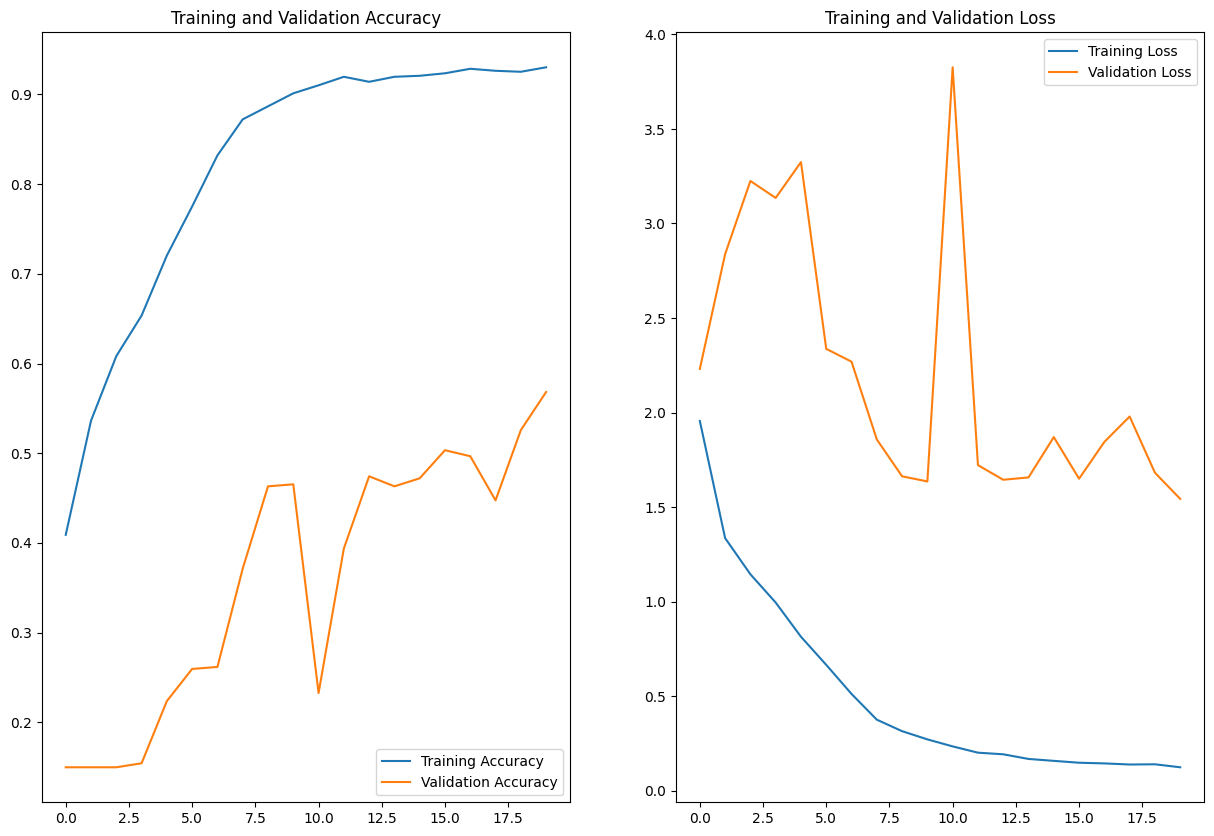

In [84]:
plot_model_accuracy(final_model_with_batch_normalisation, epochs)

#### Observations:
- Training Accuracy = 92.59 %
- Validation Accuracy = 45.19 %
- As the training progressed, both the training accuracy and the validation accuracy kept increasing.
- Difference between the training and validation accuracies did not show any improvement. 
- Model is **overfitting**.

## 3.4 Simple Model with 2 Convolution, 1 Dense Layer with Dropout and Batch Normalisation

In [85]:
input_shape = (image_height, image_width, 3)
num_classes = len(train_images_ds.class_names)
model_with_batch_normalisation_and_dropouts = models.Sequential()

# 0th Input Layer
model_with_batch_normalisation_and_dropouts.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer 
model_with_batch_normalisation_and_dropouts.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_with_batch_normalisation_and_dropouts.add(BatchNormalization())
model_with_batch_normalisation_and_dropouts.add(MaxPooling2D(2,2))
model_with_batch_normalisation_and_dropouts.add(Dropout(0.25))

# 2nd Convolution Layer
model_with_batch_normalisation_and_dropouts.add(Conv2D(64, 3, activation='relu'))
model_with_batch_normalisation_and_dropouts.add(BatchNormalization())
model_with_batch_normalisation_and_dropouts.add(MaxPooling2D(2,2))
model_with_batch_normalisation_and_dropouts.add(Dropout(0.25))

# 3rd Dense Layer
model_with_batch_normalisation_and_dropouts.add(Flatten())
model_with_batch_normalisation_and_dropouts.add(Dense(128, activation='relu'))
model_with_batch_normalisation_and_dropouts.add(BatchNormalization()),
model_with_batch_normalisation_and_dropouts.add(Dropout(0.25))

# 4th Output Layer
model_with_batch_normalisation_and_dropouts.add(Dense(num_classes, activation='softmax'))

model_with_batch_normalisation_and_dropouts.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_batch_normalisation_and_dropouts.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [86]:
final_model_with_batch_normalisation_and_dropouts = model_with_batch_normalisation_and_dropouts.fit(train_images_ds, validation_data=validation_images_ds, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 391ms/step - accuracy: 0.3368 - loss: 2.2694 - val_accuracy: 0.1499 - val_loss: 2.5110
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.4817 - loss: 1.5593 - val_accuracy: 0.1499 - val_loss: 3.0993
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.5159 - loss: 1.4268 - val_accuracy: 0.1499 - val_loss: 3.1250
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 414ms/step - accuracy: 0.5491 - loss: 1.3042 - val_accuracy: 0.1499 - val_loss: 4.0074
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.5919 - loss: 1.1526 - val_accuracy: 0.1499 - val_loss: 5.1162
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - accuracy: 0.6432 - loss: 1.0345 - val_accuracy: 0.1521 - val_loss: 4.2374
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 401ms/step - accuracy: 0.6754 - loss: 0.8989 - val_accuracy: 0.1588 - val_loss: 3.6017
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 398ms/step - accuracy: 0.7259 - loss: 0.7667 - val_accu

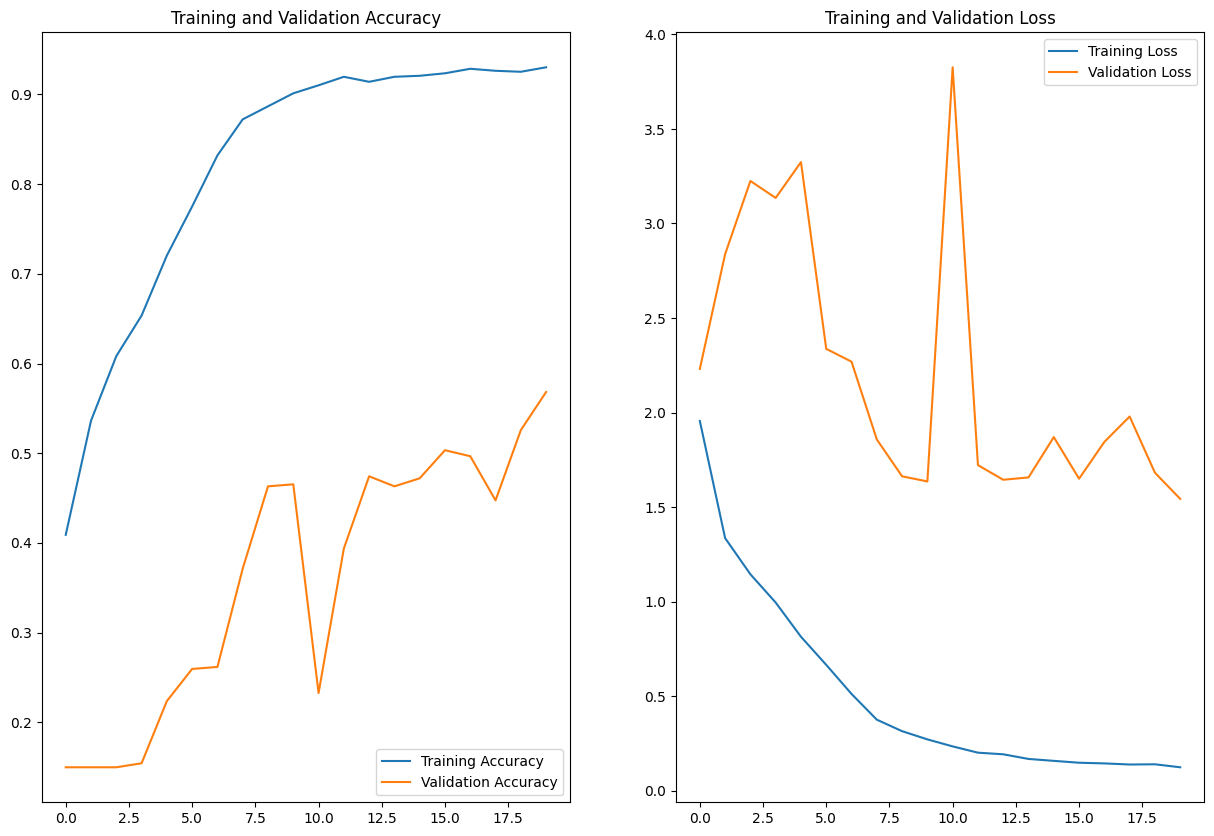

In [87]:
plot_model_accuracy(final_model_with_batch_normalisation, epochs)

#### Observations:
- Training Accuracy = 92.59 %
- Validation Accuracy = 45.19 %
- As the training progressed, training accuracy kept increasing while validation accuracy was unstable.
- Difference between the training and validation accuracies did not show any improvement. 
- Model is **overfitting**.

## 3.5 Simple Model with 1 Data Augmentation, 2 Convolution, 1 Dense Layer

In [88]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape), 
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

model_with_augumentation = models.Sequential()

# 0th Input Layer
model_with_augumentation.add(data_augmentation)
model_with_augumentation.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer 
model_with_augumentation.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_with_augumentation.add(MaxPooling2D(2,2))

# 2nd Convolution Layer
model_with_augumentation.add(Conv2D(64, 3, activation='relu'))
model_with_augumentation.add(MaxPooling2D(2,2))

# 3rd Dense Layer
model_with_augumentation.add(Flatten())
model_with_augumentation.add(Dense(128, activation='relu'))

# 4th Output Layer
model_with_augumentation.add(Dense(num_classes, activation='softmax'))

model_with_augumentation.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_augumentation.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
final_model_with_augumentation = model_with_augumentation.fit(train_images_ds, validation_data=validation_images_ds, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - accuracy: 0.2121 - loss: 4.2992 - val_accuracy: 0.4362 - val_loss: 1.6922
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.4136 - loss: 1.6424 - val_accuracy: 0.5213 - val_loss: 1.4827
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.4768 - loss: 1.4965 - val_accuracy: 0.4989 - val_loss: 1.5157
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.4701 - loss: 1.4783 - val_accuracy: 0.4832 - val_loss: 1.4391
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.5071 - loss: 1.3916 - val_accuracy: 0.4161 - val_loss: 1.6227
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.4628 - loss: 1.5665 - val_accuracy: 0.4810 - val_loss: 1.5206
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.4918 - loss: 1.4613 - val_accuracy: 0.5391 - val_loss: 1.3606
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.5139 - loss: 1.3845 - val_accu

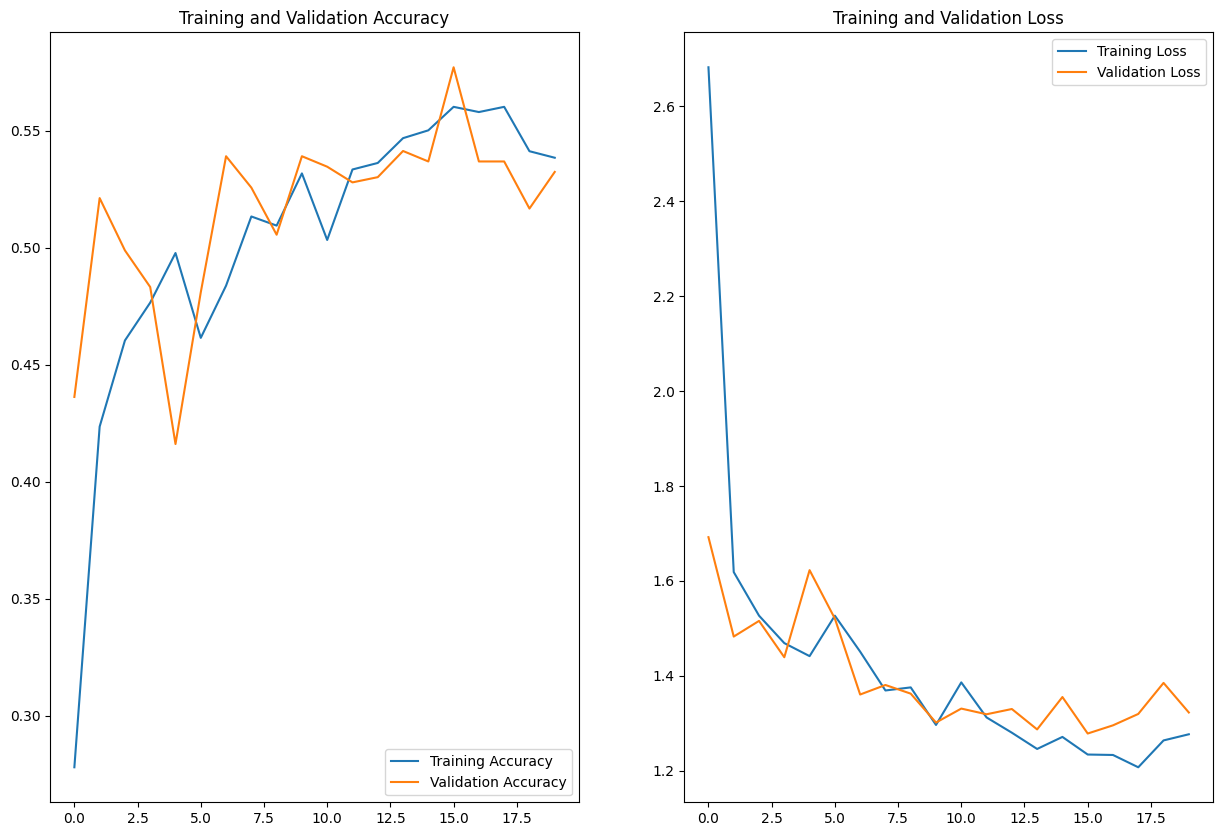

In [90]:
plot_model_accuracy(final_model_with_augumentation, epochs)

#### Observations:
- Training Accuracy = 56.33 %
- Validation Accuracy = 54.14 %
- Striking improvement in the narrowing of accuracies between the training and the validation accuracy 
- Augumentation seems to be solving the problem of overfitting.
- The lower accuracy of the training and validation still persists.

# 4. Check Class distribution

In [91]:
train_file_path_list = [ x for x in glob(os.path.join(train_dir, '*', '*.jpg')) ] 
train_dir_path_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_dir, '*', '*.jpg')) ]
file_dir_map = dict(zip(train_file_path_list, train_dir_path_list))
file_dir_df = pd.DataFrame(list(file_dir_map.items()), columns=['Path','Label'])

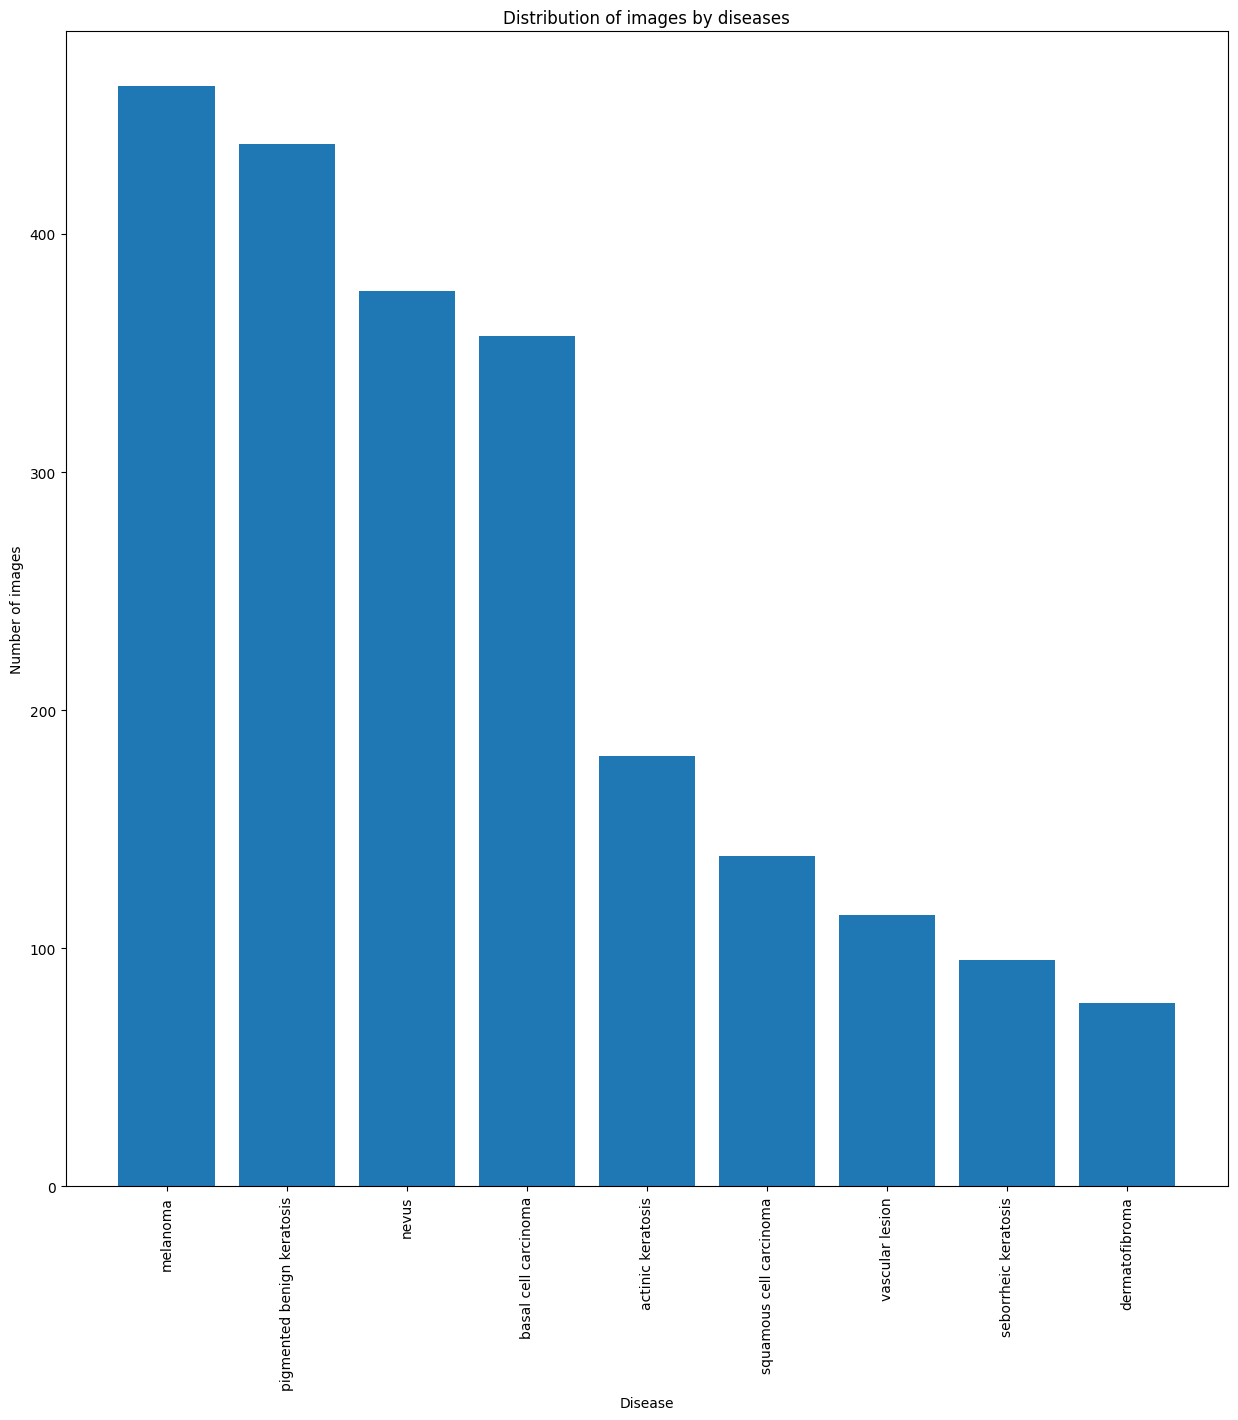

In [92]:
fig, ax = plt.subplots(figsize=(15, 15))

disease_name = file_dir_df.Label.unique()
disease_count = file_dir_df.Label.value_counts()

ax.bar(disease_name, disease_count)

ax.set_ylabel('Number of images')
ax.set_xlabel('Disease')
plt.xticks(rotation=90)
ax.set_title('Distribution of images by diseases')

plt.show()

#### Observations:
- There seems to be a abnormal distribution of images for different diseases.
- Diseases with abnormally low count of images:

| Name | Count |
|-|-|
| vascular lesion | 139 |
| actinic keratosis | 114 |
| dermatofibroma | 95 |
| seborrheic keratosis | 77 |

# 5. Augumenting the input data

In [93]:
import Augmentor
for i in train_images_ds.class_names:
    input_dir = os.path.dirname(train_dir) + '/train/' + i
    print(input_dir)
    p = Augmentor.Pipeline(input_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

../../datasets/images/melanoma/train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17EF15E50>: 100%|██████████| 500/500 [00:02<00:00, 245.57 Samples/s]


../../datasets/images/melanoma/train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x30EEA1890>: 100%|██████████| 500/500 [00:01<00:00, 264.60 Samples/s]


../../datasets/images/melanoma/train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17EF21810>: 100%|██████████| 500/500 [00:02<00:00, 247.56 Samples/s]                  


../../datasets/images/melanoma/train/melanoma
Initialised with 438 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x320FCD490>: 100%|██████████| 500/500 [00:08<00:00, 56.13 Samples/s]                   


../../datasets/images/melanoma/train/nevus
Initialised with 357 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x17EF5B350>: 100%|██████████| 500/500 [00:07<00:00, 66.64 Samples/s]                  


../../datasets/images/melanoma/train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16319AA90>: 100%|██████████| 500/500 [00:01<00:00, 264.01 Samples/s]                  


../../datasets/images/melanoma/train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1783D4410>: 100%|██████████| 500/500 [00:03<00:00, 125.89 Samples/s]                  


../../datasets/images/melanoma/train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x30EEB2F90>: 100%|██████████| 500/500 [00:02<00:00, 246.43 Samples/s]


../../datasets/images/melanoma/train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to ../../datasets/images/melanoma/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17861E190>: 100%|██████████| 500/500 [00:01<00:00, 272.57 Samples/s]                  


In [94]:
augumented_train_file_path_list = [ x for x in glob(os.path.join(train_dir, '*', 'output', '*.jpg')) ] 
augumented_train_dir_path_list = [ os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*', 'output', '*.jpg')) ]
augumented_file_dir_map = dict(zip(augumented_train_file_path_list, augumented_train_dir_path_list))
augumented_file_dir_df = pd.DataFrame(list(augumented_file_dir_map.items()), columns=['Path', 'Label'])
augumented_file_dir_df._append(file_dir_df)

Path           Label
0     ../../datasets/images/melanoma/train/melanoma/...        melanoma
1     ../../datasets/images/melanoma/train/melanoma/...        melanoma
2     ../../datasets/images/melanoma/train/melanoma/...        melanoma
3     ../../datasets/images/melanoma/train/melanoma/...        melanoma
4     ../../datasets/images/melanoma/train/melanoma/...        melanoma
...                                                 ...             ...
2234  ../../datasets/images/melanoma/train/dermatofi...  dermatofibroma
2235  ../../datasets/images/melanoma/train/dermatofi...  dermatofibroma
2236  ../../datasets/images/melanoma/train/dermatofi...  dermatofibroma
2237  ../../datasets/images/melanoma/train/dermatofi...  dermatofibroma
2238  ../../datasets/images/melanoma/train/dermatofi...  dermatofibroma

[6739 rows x 2 columns]

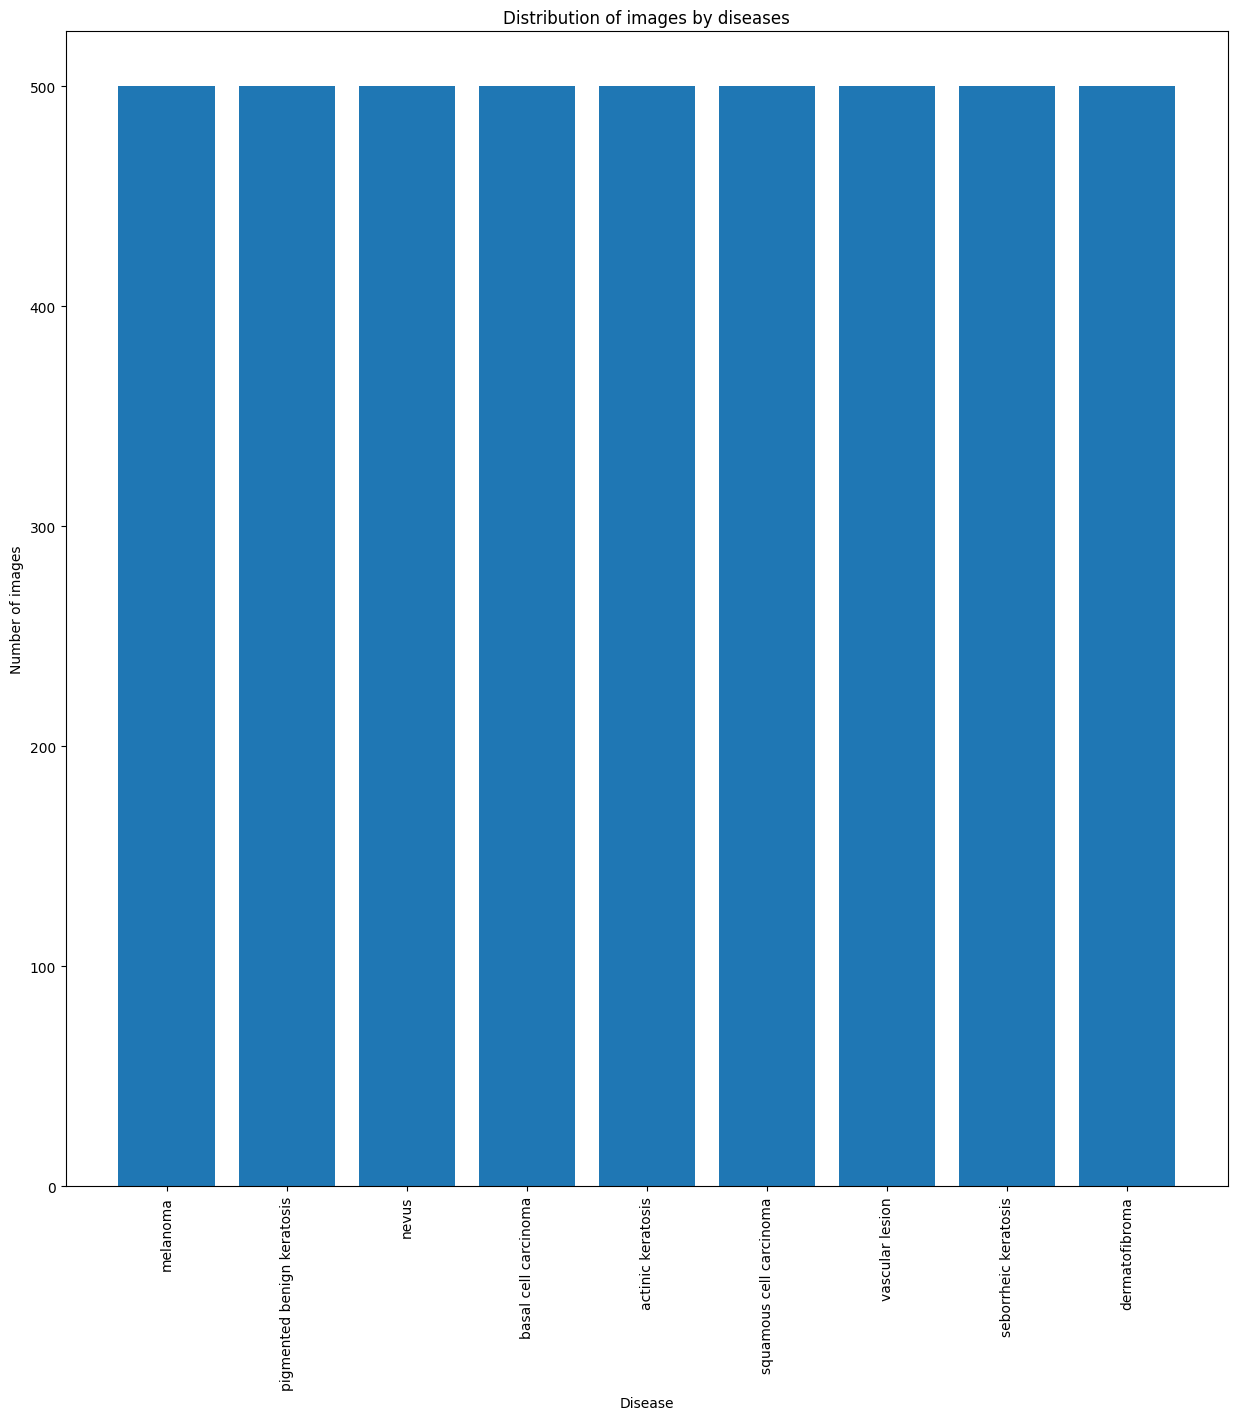

In [95]:
fig, ax = plt.subplots(figsize=(15, 15))

disease_name = augumented_file_dir_df.Label.unique()
disease_count = augumented_file_dir_df.Label.value_counts()

ax.bar(disease_name, disease_count)

ax.set_ylabel('Number of images')
ax.set_xlabel('Disease')
plt.xticks(rotation=90)
ax.set_title('Distribution of images by diseases')

plt.show()

In [96]:
train_images_class_balanced_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    validation_split=validate_split,
    subset='training',
    seed=seed
    )

validation_images_class_balanced_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width),    
    validation_split=validate_split,
    subset='validation',
    seed=seed)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# 6. Create the model

## 6.1 Simple Model with 2 Convolution and 1 Dense Layers

In [97]:
input_shape = (image_height, image_width, 3)
num_classes = len(train_images_class_balanced_ds.class_names)
model_with_class_balanced = models.Sequential()

# 0th Input Layer
model_with_class_balanced.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer
model_with_class_balanced.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_with_class_balanced.add(MaxPooling2D(2,2))

# 2nd Convolution Layer
model_with_class_balanced.add(Conv2D(64, 3, activation='relu'))
model_with_class_balanced.add(MaxPooling2D(2,2))

# 3rd Dense Layer
model_with_class_balanced.add(Flatten())
model_with_class_balanced.add(Dense(128, activation='relu'))

# 4th Output Layer
model_with_class_balanced.add(Dense(num_classes, activation='softmax'))

model_with_class_balanced.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_class_balanced.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
final_model_with_class_balanced = model_with_class_balanced.fit(train_images_class_balanced_ds, validation_data=validation_images_class_balanced_ds, epochs=20)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.2126 - loss: 2.5361 - val_accuracy: 0.3318 - val_loss: 1.7450
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.3874 - loss: 1.5844 - val_accuracy: 0.4922 - val_loss: 1.4598
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.5041 - loss: 1.3391 - val_accuracy: 0.5137 - val_loss: 1.4122
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.5802 - loss: 1.1650 - val_accuracy: 0.5969 - val_loss: 1.1832
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.6566 - loss: 0.9455 - val_accuracy: 0.6266 - val_loss: 1.0661
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.7331 - loss: 0.7668 - val_accuracy: 0.6763 - val_loss: 1.0007
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.7933 - loss: 0.5921 - val_accuracy: 0.7075 - val_loss: 0.9580
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - accuracy: 0.8374 - loss: 0

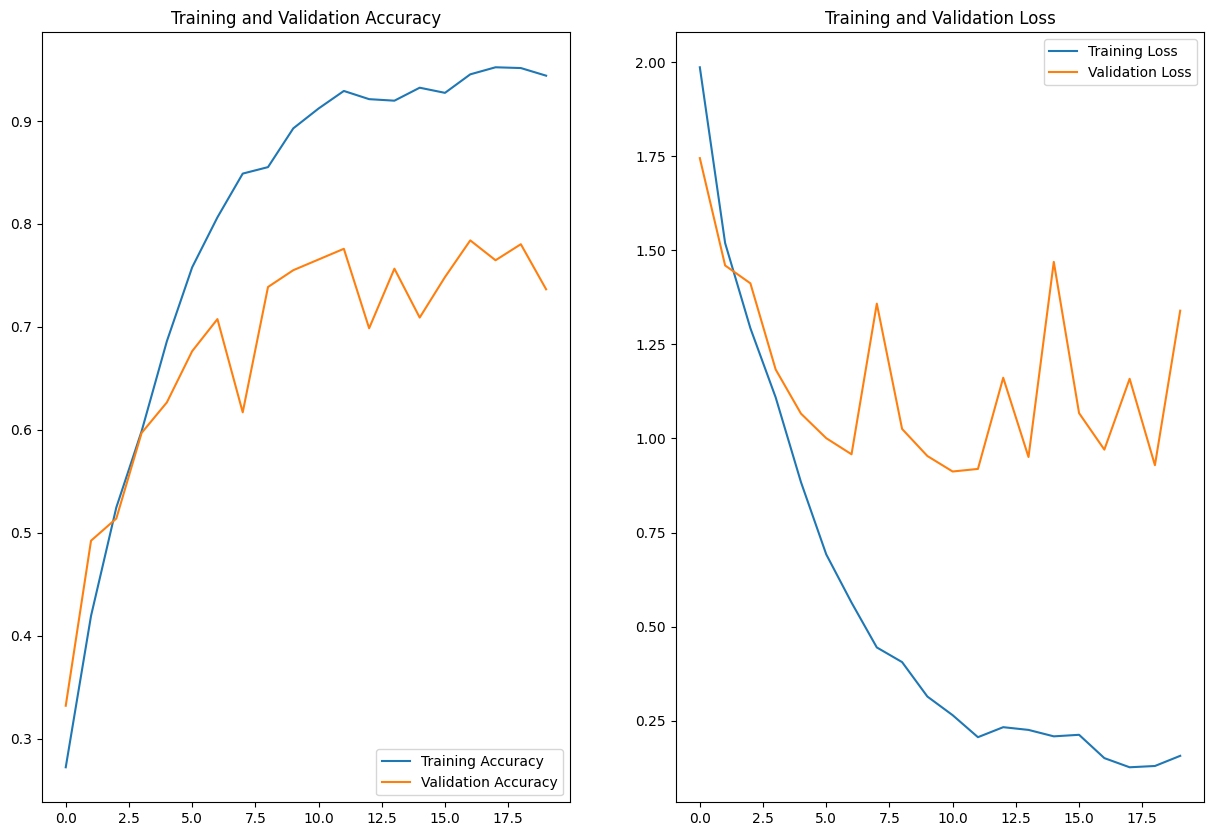

In [99]:
plot_model_accuracy(final_model_with_class_balanced, epochs)

#### Observations:
- Training Accuracy = 96 %
- Validation Accuracy = 80 %
- Augmentation & Class Balancing helped boost the Validation Accuracy.
- There is still some difference between the training and validation accuracy which seems to be due to overfitting.

## 6.2 Simple Model with 2 Convolution, 1 Dense Layer and Dropout Layers


In [100]:
input_shape = (image_height, image_width, 3)
num_classes = len(train_images_class_balanced_ds.class_names)
model_with_class_balanced_dropout = models.Sequential()

# 0th Input Layer
model_with_class_balanced_dropout.add(Rescaling(1./255, input_shape=input_shape))

# 1st Convolution Layer 
model_with_class_balanced_dropout.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_with_class_balanced_dropout.add(MaxPooling2D(2,2))
model_with_class_balanced_dropout.add(Dropout(0.25))

# 2nd Convolution Layer
model_with_class_balanced_dropout.add(Conv2D(64, 3, activation='relu'))
model_with_class_balanced_dropout.add(MaxPooling2D(2,2))
model_with_class_balanced_dropout.add(Dropout(0.25))

# 3rd Dense Layer
model_with_class_balanced_dropout.add(Flatten())
model_with_class_balanced_dropout.add(Dense(128, activation='relu'))
model_with_class_balanced_dropout.add(Dropout(0.25))

# 4th Output Layer
model_with_class_balanced_dropout.add(Dense(num_classes, activation='softmax'))

model_with_class_balanced_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_class_balanced_dropout.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
final_model_with_class_balanced_dropout = model_with_class_balanced_dropout.fit(train_images_class_balanced_ds, validation_data=validation_images_class_balanced_ds, epochs=20)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.1564 - loss: 3.5692 - val_accuracy: 0.3846 - val_loss: 1.8242
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.3475 - loss: 1.7521 - val_accuracy: 0.4506 - val_loss: 1.5745
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.4600 - loss: 1.4430 - val_accuracy: 0.5204 - val_loss: 1.4268
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.5308 - loss: 1.3046 - val_accuracy: 0.5293 - val_loss: 1.3536
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.5818 - loss: 1.1541 - val_accuracy: 0.6036 - val_loss: 1.1342
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.6186 - loss: 1.0459 - val_accuracy: 0.6340 - val_loss: 1.0894
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.6622 - loss: 0.9297 - val_accuracy: 0.6667 - val_loss: 1.0343
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.7066 - loss: 0

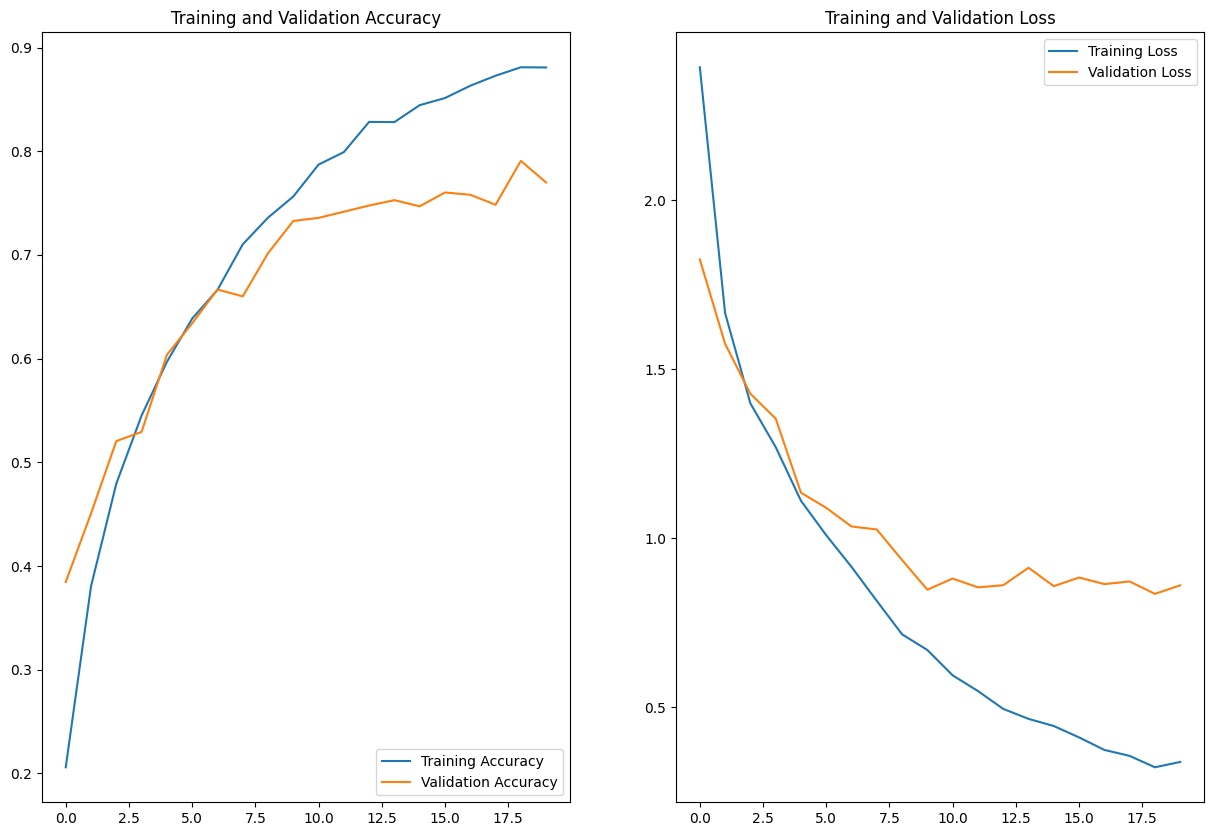

In [102]:
plot_model_accuracy(final_model_with_class_balanced_dropout, epochs)

#### Observations:
- Training Accuracy = 90 %
- Validation Accuracy = 84 %
- Augmentation & Class Balancing helped boost the Validation Accuracy.
- Dropout helped in improving the overfitting of the model. 
- Using this as the final model.

In [103]:
model.evaluate(test_images_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3559 - loss: 6.1608


[6.444023132324219, 0.32203391194343567]